<a href="https://colab.research.google.com/github/ospikovets/linear-algebra-projector/blob/main/Pikovets_HW_2_Linear_Algebra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [288]:
import typing as t
import functools

import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
from sklearn.cluster import KMeans


def build_diffs(
  vectors: t.Sequence[np.ndarray]
) -> tuple[np.ndarray, np.ndarray]:
  """Build a set of diff vectors from the combination of input vectors.

  For the 2 vectors `vectors[0]` and `vectors[1]`,
  only `vectors[0] - vectors[1]` is built to optimize the function.

  Therefore, for the `n` vectors, the function returns `n(n-1)/2` diffs.

  Returns:
    diff: array of diff vectors created from the input vectors.
    diff_id: array of diff vectors identifiers,
      created from the indexex on the original vectors.
      For diff vector created as `vectors[0] - vectors[1]`,
      the identifier is `np.array([1, 0])`.

  Raises:
    ValueError: in case
  """

  if len(vectors) < 2:
    raise ValueError("at least 2 vectors are required to build diffs")

  vectors_count = len(vectors)
  diffs_count = int(vectors_count * (vectors_count - 1) / 2)
  dims_count = vectors[0].size
  dtype = np.max([v.dtype for v in vectors])

  diff_id = np.zeros(shape=(diffs_count, 2), dtype=int)
  diff = np.zeros(shape=(diffs_count, dims_count), dtype=dtype)

  filled_count = 0
  for i, subtrahend in enumerate(vectors[:-1]):
    minuends = vectors[i+1:]
    batch_size = len(minuends)

    selector = slice(filled_count, filled_count + batch_size)
    diff[selector] = minuends - subtrahend
    diff_id[selector, 0] = i
    diff_id[selector, 1] = np.arange(i + 1, i + 1 + batch_size)

    filled_count += batch_size

  return diff, diff_id


def find_closest_from_diff(diff, diff_id, *, n=1, norm=None):
    norm = norm or functools.partial(LA.norm, axis=1)

    diff_indices = np.arange(len(diff))

    norms = norm(diff)
    sorting_indices = np.argsort(norms)

    sorted_diff_id = diff_id[sorting_indices]
    sorted_norm = norms[sorting_indices]

    v_ids = np.unique(diff_id)
    vectors_count = len(v_ids)
    n = min(n, vectors_count - 1)

    shape = (vectors_count, n)
    closest = np.full(shape, fill_value=-1, dtype=diff_id.dtype)
    distances = np.zeros(shape, dtype=norms.dtype)

    for i, v_id in enumerate(v_ids):
      diff_mask = np.any(sorted_diff_id == v_id, axis=1)

      rel_diff_indices = diff_indices[diff_mask]
      limited_diff_indices = rel_diff_indices[:n]

      relevant_norm = sorted_norm[limited_diff_indices]
      relevant_diff_id = sorted_diff_id[limited_diff_indices]

      closest[i] = relevant_diff_id[relevant_diff_id != v_id]
      distances[i] = relevant_norm

    return closest, distances


def find_closest(vectors: np.ndarray, *, n=1, norm=None) -> tuple[np.ndarray, np.ndarray]:
    """Find up to `n` closest vectors for each vector in vectors.

    If `n` is larger than `len(vectors) - 1`,
    the `len(vectors) - 1` closest vectors will be returned.

    Returns:
      closest: an array of the same lenght as `vectors`,
        containing up to `n` ids of the corresponding closest vectors.
      distances: an array of the same shape as closest,
        containing a distance from the vector
        to the corresponding closest vector.
    """
    diff, diff_id = build_diffs(vectors)
    return find_closest_from_diff(diff, diff_id, n=n, norm=norm)


class KNN:
  def __init__(self, k, norm=None):
    self.k = k
    self.norm = norm or LA.norm
    self.X = None
    self.Y = None

  def fit(self, X, Y):
    self.X = X
    self.Y = Y

  def predict(self, data):
    diff = self.X[:, np.newaxis, :] - data[np.newaxis, :, :]
    distances = self.norm(diff, axis=-1)

    sorting_indices = np.argsort(distances, axis=0)[:self.k]
    knn = self.Y[sorting_indices]

    return knn.sum(axis=0) / self.k

# Homework 2 (Normed Vector Spaces)

## Required

### Task 1

Check whether the following norm `L` is legitimate:

```
L(v) = 0, if v=0
L(v) = 1, if v≠0
```

For the norm to be legitimate, it should satisfy the following 4 axioms:

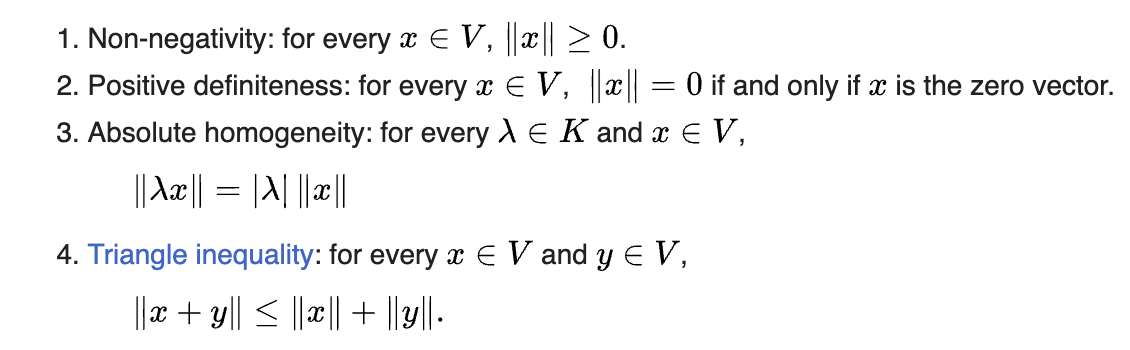

While the described norm satisfies the first 2, it does not satisfy the third one, as

```
||2x|| != |2| ||x||
1 != 2
```

### Task 2

Find the nearest vector for each vector from the following group of vectors:
```
a = (0, -1, 1)
b = (0, 4, 0)
c = (2, 1, 4)
```

Measure distances using 3 metrics: L1, L2, L∞.

`||x||∞ = maxj( |xj| )`

In [273]:
labels = np.array(["a", "b", "c"])
vectors = np.array(
  [
    [0, -1, 1],
    [0, 4, 0],
    [2, 1, 4],
  ]
)

diff, diff_ids = build_diffs(vectors)
diff_labels = labels[diff_ids]

print(pd.DataFrame(zip(diff_labels, diff), columns=["Vector", "Coordinates"]))

   Vector Coordinates
0  [a, b]  [0, 5, -1]
1  [a, c]   [2, 2, 3]
2  [b, c]  [2, -3, 4]


In [274]:
norm = functools.partial(LA.norm, ord=1, axis=1)
closest, distances = find_closest_from_diff(diff, diff_ids, norm=norm)

print(pd.DataFrame(zip(diff_labels, diff, norm(diff)), columns=["Vector", "Coordinates", "L1 Norm"]).to_string(index=False))
print()
print(pd.DataFrame(zip(labels.T, labels[closest], distances), columns=["Vector", f"Closest Vector(s)", "L1 Norm(s)"]).to_string(index=False))

Vector Coordinates  L1 Norm
[a, b]  [0, 5, -1]      6.0
[a, c]   [2, 2, 3]      7.0
[b, c]  [2, -3, 4]      9.0

Vector Closest Vector(s) L1 Norm(s)
     a               [b]      [6.0]
     b               [a]      [6.0]
     c               [a]      [7.0]


In [275]:
norm = functools.partial(LA.norm, ord=None, axis=1)
closest, distances = find_closest_from_diff(diff, diff_ids, norm=norm)

print(pd.DataFrame(zip(diff_labels, diff, norm(diff)), columns=["Vector", "Coordinates", "L2 Norm"]).to_string(index=False))
print()
print(pd.DataFrame(zip(labels.T, labels[closest], distances), columns=["Vector", f"Closest Vector(s)", "L2 Norm(s)"]).to_string(index=False))

Vector Coordinates  L2 Norm
[a, b]  [0, 5, -1] 5.099020
[a, c]   [2, 2, 3] 4.123106
[b, c]  [2, -3, 4] 5.385165

Vector Closest Vector(s)           L2 Norm(s)
     a               [c]  [4.123105625617661]
     b               [a] [5.0990195135927845]
     c               [a]  [4.123105625617661]


In [276]:
norm = functools.partial(LA.norm, ord=np.inf, axis=1)
closest, distances = find_closest_from_diff(diff, diff_ids, norm=norm)

print(pd.DataFrame(zip(diff_labels, diff, norm(diff)), columns=["Vector", "Coordinates", "L∞ Norm"]).to_string(index=False))
print()
print(pd.DataFrame(zip(labels.T, labels[closest], distances), columns=["Vector", f"Closest Vector(s)", "L∞ Norm(s)"]).to_string(index=False))

Vector Coordinates  L∞ Norm
[a, b]  [0, 5, -1]      5.0
[a, c]   [2, 2, 3]      3.0
[b, c]  [2, -3, 4]      4.0

Vector Closest Vector(s) L∞ Norm(s)
     a               [c]      [3.0]
     b               [c]      [4.0]
     c               [a]      [3.0]


### Task 3

For `x` from `x1=0` to `x2=8` plot the function y using `KNN`.
Take `k=2` and the dataset of pairs `(x, y)`.

```
data = [(0, 1), (3, 5), (4, 3), (7, 4)]
```

In [277]:
train_data = np.array([(0, 1), (3, 5), (4, 3), (7, 4)])
X = train_data.T[:-1].T
Y = train_data.T[1]

X, Y

(array([[0],
        [3],
        [4],
        [7]]),
 array([1, 5, 3, 4]))

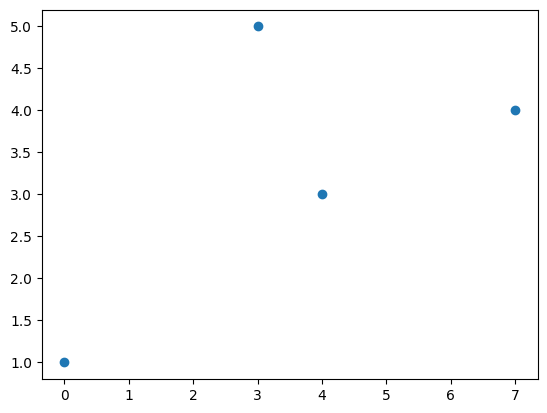

In [278]:
fig, ax = plt.subplots()
ax.scatter(X, Y)
plt.show()

In [279]:
data = np.linspace([0], [8])
data

array([[0.        ],
       [0.16326531],
       [0.32653061],
       [0.48979592],
       [0.65306122],
       [0.81632653],
       [0.97959184],
       [1.14285714],
       [1.30612245],
       [1.46938776],
       [1.63265306],
       [1.79591837],
       [1.95918367],
       [2.12244898],
       [2.28571429],
       [2.44897959],
       [2.6122449 ],
       [2.7755102 ],
       [2.93877551],
       [3.10204082],
       [3.26530612],
       [3.42857143],
       [3.59183673],
       [3.75510204],
       [3.91836735],
       [4.08163265],
       [4.24489796],
       [4.40816327],
       [4.57142857],
       [4.73469388],
       [4.89795918],
       [5.06122449],
       [5.2244898 ],
       [5.3877551 ],
       [5.55102041],
       [5.71428571],
       [5.87755102],
       [6.04081633],
       [6.20408163],
       [6.36734694],
       [6.53061224],
       [6.69387755],
       [6.85714286],
       [7.02040816],
       [7.18367347],
       [7.34693878],
       [7.51020408],
       [7.673

In [280]:
m = KNN(2)
m.fit(X, Y)
Yp = m.predict(data)
Yp

array([3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. ,
       4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4. , 4. , 4. , 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5,
       3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5])

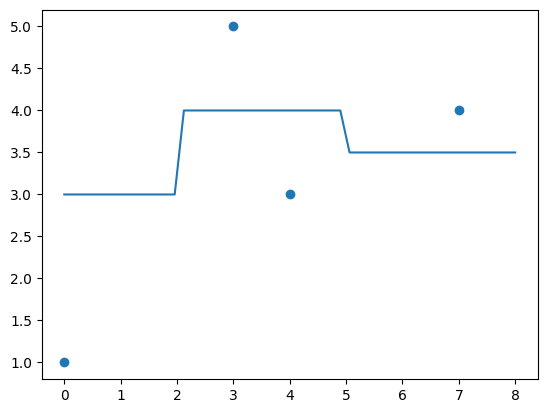

In [281]:
fig, ax = plt.subplots()
ax.plot(data, Yp)
ax.scatter(X, Y)
plt.show()

### Task 4

What would you use normalization or
standardization for the datasets below. Why?

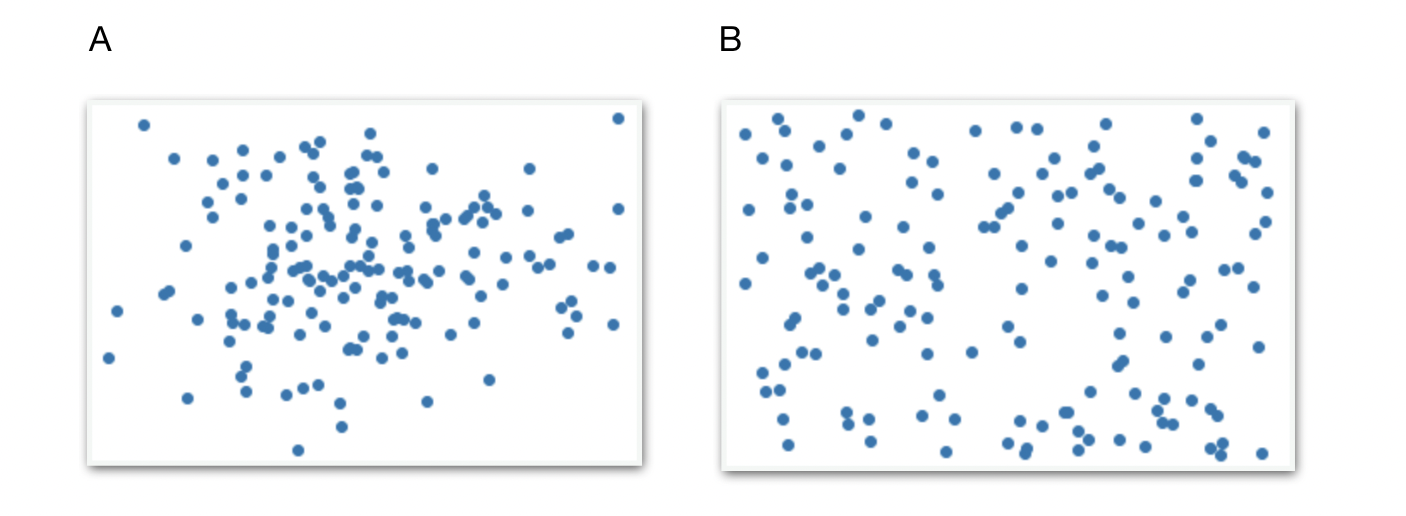

In the case `A` it is likelly that standardization will work better, than normalization as it looks like the data has a higher dencity around the center of the cluster and lower dencity further away from it.

In the case `B`, the data looks to be equaly distributed over the space and there is no obvious area with higher data points density, therefore, normalization will likelly be better for `B`.

## Optional

### Task 5

Find clusters in the dataset contained in `clusters.csv` file. You can use kmeans or any other available clustering methods.

In [286]:
X = np.genfromtxt("drive/MyDrive/Colab Notebooks/clusters.csv", delimiter=",")
X, X.shape

(array([[ 2.15387311e+00,  8.52656786e-01,  3.62951063e+00],
        [ 4.64525419e+00,  1.12401300e+00,  4.30477545e-01],
        [ 2.66200859e+00,  4.15881149e+00,  4.43239911e+00],
        [ 2.30583928e+00,  1.72332477e+00, -6.82017363e-01],
        [ 8.91654286e-01,  1.29230801e+00,  5.18933700e+00],
        [ 5.18127684e+00,  6.34454563e-01,  2.99459572e+00],
        [ 1.30300719e+00,  4.96671224e+00,  4.74086876e-01],
        [ 2.31711433e+00,  2.93441030e+00,  6.20087662e+00],
        [ 4.58432464e-02,  1.47914854e+00,  4.91910092e+00],
        [ 2.03344969e+00,  1.44810764e+00,  4.17047502e+00],
        [ 4.38964286e+00, -5.67627209e-01,  2.29914281e+00],
        [ 1.97001669e-01,  3.62044810e-01,  6.10138996e+00],
        [ 3.45520873e+00,  7.16839610e-02,  4.76645227e+00],
        [ 7.00809476e-01,  6.30989539e+00, -2.53936811e+00],
        [ 7.52912228e-01,  2.35361482e+00, -2.07647511e-01],
        [ 1.71919156e-01,  5.89328535e+00, -4.78684188e-01],
        [ 1.22156676e+00

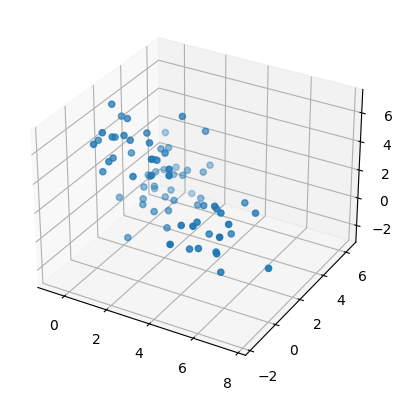

In [300]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X.T[0], X.T[1], X.T[2])
plt.show()

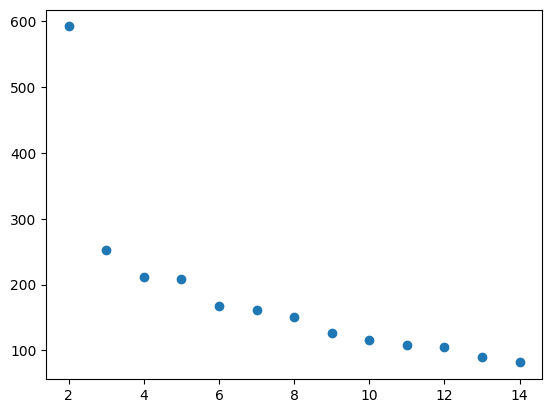

In [296]:
# Let's choose the number of clusters, using "elbow method"
ccs = np.arange(2, 15)
inertia = np.zeros(ccs.shape)

for i, cc in enumerate(ccs):
  m = KMeans(cc, n_init="auto")
  m.fit(X)
  inertia[i] = m.inertia_

fig, ax = plt.subplots()
ax.scatter(ccs, inertia)
plt.show()

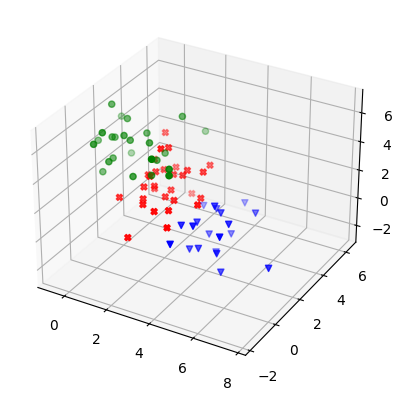

In [321]:
# From the above figure, chosing the number of clusters to be 3
m = KMeans(3, n_init="auto")

clusters = m.fit_predict(X)
markers = ['X', 'o', 'v']
colors = ["r", "g", "b"]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for cluster, (color, marker) in enumerate(zip(colors, markers)):
  CX = X[clusters == cluster]
  ax.scatter(CX.T[0], CX.T[1], CX.T[2], marker=marker, c=color)

plt.show()